In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
# Load Dataset
df = pd.read_csv("Binary.csv")

In [3]:
# Splitting Data
X = df.drop(columns=["target"])  # Features
y = df["target"].values          # Target Variable

In [4]:
# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Convert to PyTorch tensors
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [7]:
# Create PyTorch Dataloader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
class OptimizedMLP(nn.Module):
    def __init__(self, input_size):
        super(OptimizedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)  # Ensure output is 1

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Regularization
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))  # ✅ Keep this ReLU
        x = self.fc4(x)  # ✅ Do not apply activation before final layer
        return self.sigmoid(x)  # ✅ Sigmoid at the final output

In [9]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedMLP(input_size=X_train.shape[1]).to(device)

In [10]:
# Loss and Optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5) # L2 Regularization
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning Rate Scheduler

In [11]:
# Training Loop with Early Stopping
epochs = 100
best_val_loss = float("inf")
patience = 10  # Stop if validation loss doesn't improve for 5 consecutive epochs
patience_counter = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    scheduler.step()
    
    # Compute Validation Loss
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/100], Loss: 0.6030, Val Loss: 0.5120
Epoch [2/100], Loss: 0.4325, Val Loss: 0.3696
Epoch [3/100], Loss: 0.3532, Val Loss: 0.3397
Epoch [4/100], Loss: 0.3202, Val Loss: 0.3068
Epoch [5/100], Loss: 0.2759, Val Loss: 0.2790
Epoch [6/100], Loss: 0.2458, Val Loss: 0.2602
Epoch [7/100], Loss: 0.2204, Val Loss: 0.2392
Epoch [8/100], Loss: 0.1904, Val Loss: 0.2351
Epoch [9/100], Loss: 0.1687, Val Loss: 0.2333
Epoch [10/100], Loss: 0.1442, Val Loss: 0.2346
Epoch [11/100], Loss: 0.1204, Val Loss: 0.2355
Epoch [12/100], Loss: 0.1171, Val Loss: 0.2363
Epoch [13/100], Loss: 0.1181, Val Loss: 0.2369
Epoch [14/100], Loss: 0.1256, Val Loss: 0.2379
Epoch [15/100], Loss: 0.1098, Val Loss: 0.2390
Epoch [16/100], Loss: 0.1166, Val Loss: 0.2390
Epoch [17/100], Loss: 0.1133, Val Loss: 0.2396
Epoch [18/100], Loss: 0.1067, Val Loss: 0.2404
Epoch [19/100], Loss: 0.1015, Val Loss: 0.2407
Early stopping triggered.


In [12]:
# Model Evaluation
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor.to(device)).cpu().numpy()
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

In [13]:
# Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_binary, average="binary")
cm = confusion_matrix(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

Precision: 0.9588, Recall: 0.9894, F1-Score: 0.9738


In [19]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[11  4]
 [ 1 93]]


In [20]:
# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# Compute Sensitivity & Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Sensitivity: 0.9894
Specificity: 0.7333


In [14]:
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.9541
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        15
           1       0.96      0.99      0.97        94

    accuracy                           0.95       109
   macro avg       0.94      0.86      0.89       109
weighted avg       0.95      0.95      0.95       109



(array([0.5, 1.5]), [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

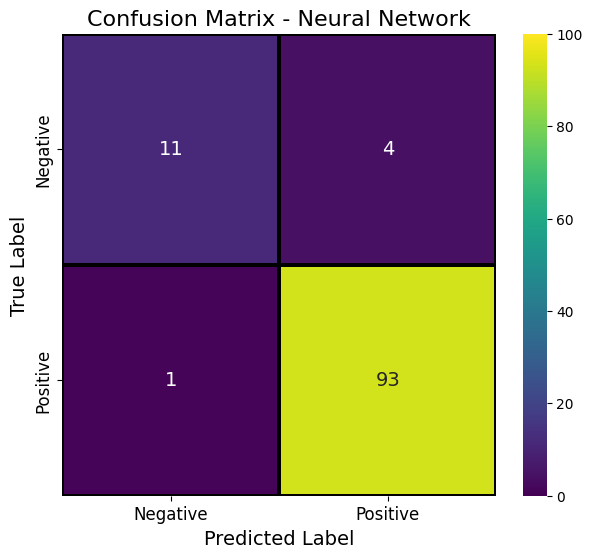

In [18]:
# Plot Confusion Matrix
plt.figure(figsize=(7,6))  # Increase figure size
ax = sns.heatmap(cm, annot=True, fmt='.0f', cmap='viridis', 
                 linewidths=1.5, linecolor='black', 
                 annot_kws={"size": 14}, vmin=0, vmax=100,
                 xticklabels=['Negative', 'Positive'], 
                 yticklabels=['Negative', 'Positive'])


plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix - Neural Network", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

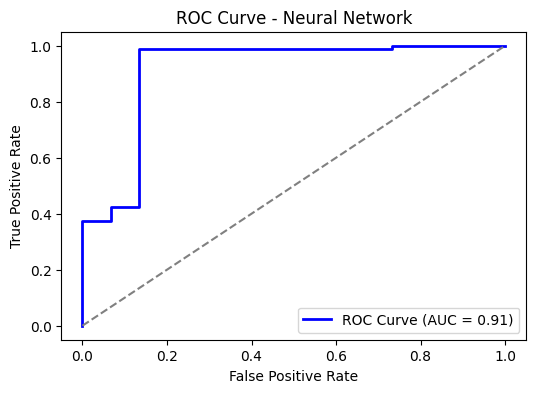

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="grey", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Neural Network")
plt.legend(loc="lower right")
plt.show()